## Семинар 9: "LSTM"[SOLVED]

ФИО: Тимонина Дарья Сергеевна

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

In [4]:
class LSTMModel(nn.Module):
    
    def __init__(self, model, hidden_size):
        if not model==nn.LSTM and not model==LSTM:
            raise TypeError("invalid type")
        super(LSTMModel, self).__init__()
        self.num_layers = 1 # we use just one layer
        self.hidden_size = hidden_size
        self.model = model(1, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
    
    def forward(self, inp):
        if self.model.__class__ == torch.nn.modules.rnn.LSTM:
            batch_size = inp.size(0)
            self.hidden = (torch.zeros(self.num_layers, batch_size, 
                                   self.hidden_size, requires_grad=True),
                       torch.zeros(self.num_layers, batch_size, 
                                   self.hidden_size, requires_grad=True))
            inp = pack_sequence(inp)
            lstm_out, self.hidden = self.model(inp, self.hidden)
            lstm_out, _ = pad_packed_sequence(lstm_out, False)
            
        else: # self.model==LSTM
            batch_size = inp.size(1)
            hidden = (Variable(torch.zeros(batch_size, self.hidden_size)),
                    Variable(torch.zeros(batch_size, self.hidden_size)))
        
            lstm_out, self.hidden = self.model(inp, hidden)
        
        
        lstm_out = lstm_out[-1]
        out = self.linear(lstm_out.view(batch_size, self.hidden_size))
        return out

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

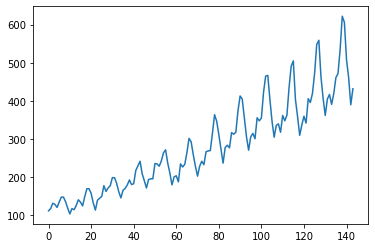

In [5]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [6]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [8]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [9]:
# Пример подготовленных данных

look_back = 30
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
trainY = trainY.reshape(trainY.shape[0])
testY = testY.reshape(testY.shape[0])
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
len(trainX)

64

In [11]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [12]:
train_dataloader =  DataLoader(train_dataset, batch_size=30)

In [13]:
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

In [14]:
test_dataloader =  DataLoader(test_dataset, batch_size=30)

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        network.zero_grad()
        X_train = torch.FloatTensor(X).view(-1, X.shape[0], 1) # nn.LSTM
        y_train = torch.FloatTensor(y).view(-1, 1)
        print(X_train.shape)
        prediction = network(X_train)
        print(prediction.shape)
        print(y_train.shape)
        loss_batch = loss(prediction, y_train)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs


In [36]:
lstm = LSTMModel(LSTM, 10)

Epoch 999... (Train/Test) NLL: 0.003/0.029	Accuracy: nan/nan


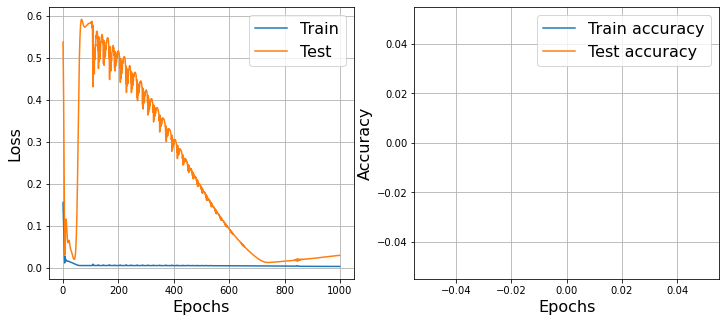

([0.15488766382137933,
  0.1319519244134426,
  0.10706193807224433,
  0.0797148576627175,
  0.05030661045263211,
  0.022239609233414132,
  0.010825718753039837,
  0.026439553126692772,
  0.024037050393720467,
  0.019150339377423126,
  0.018231085191170376,
  0.018122435702631872,
  0.01748272341986497,
  0.016352453269064426,
  0.015258962288498878,
  0.014695765605817238,
  0.014765699238826832,
  0.015110315755009651,
  0.015278238492707411,
  0.015140259638428688,
  0.014838870769987503,
  0.014502300725628933,
  0.014152295577029387,
  0.01378210773691535,
  0.013419674709439278,
  0.013115765992552042,
  0.012895303778350353,
  0.012731284679224094,
  0.012568239743510881,
  0.012366075534373522,
  0.012117002004136642,
  0.011831968867530426,
  0.011526604648679495,
  0.011218604942162832,
  0.010925083886831999,
  0.010653714959820112,
  0.010396771443386873,
  0.01013716139520208,
  0.009861023010065159,
  0.009564794600009918,
  0.00925427737335364,
  0.008940288486580053,
  0

In [37]:
train(lstm, train_dataloader, test_dataloader, 1000, 0.005)

In [23]:
testX.shape

(16, 1, 30)

In [32]:
#X_test = torch.from_numpy(X_test).view(8, 1, 1)
X_test =  torch.FloatTensor(testX).view(30, 16, 1)
prediction = lstm(X_test)

In [33]:
prediction = prediction.detach().numpy()

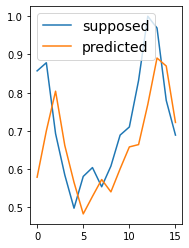

In [34]:
plt.subplot(1, 2, 2)
#supposed = dataset[train_size:len(dataset):]
plt.plot(testY, label='supposed')
plt.plot(prediction, label='predicted')
plt.legend(fontsize=14)
plt.show()

Epoch 999... (Train/Test) NLL: 0.000/0.045	Accuracy: nan/nan


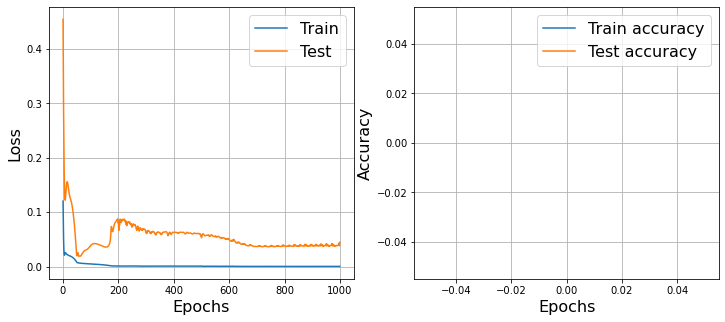

([0.12030706430474918,
  0.07670003920793533,
  0.04911989625543356,
  0.03214127849787474,
  0.023346631166835625,
  0.02090822687993447,
  0.022269014889995258,
  0.024476371705532074,
  0.025668312174578507,
  0.025583149244387943,
  0.02479325421154499,
  0.023887147506078083,
  0.023160130095978577,
  0.022655312592784565,
  0.02229850289101402,
  0.022000867407768965,
  0.021706245373934507,
  0.021398600346098345,
  0.021089579599599045,
  0.02080069063231349,
  0.02054863904292385,
  0.020337697428961594,
  0.0201594236617287,
  0.01999750252192219,
  0.019834314317752916,
  0.019656138805051643,
  0.01945530514543255,
  0.019229575991630554,
  0.018980021433283884,
  0.018708929885178804,
  0.01841852596650521,
  0.018110529364397127,
  0.017786221578717232,
  0.017446531758954126,
  0.01709189514319102,
  0.01672192740564545,
  0.016335107230891783,
  0.015928649498770635,
  0.015498711572339138,
  0.015040822637577852,
  0.014550517157961925,
  0.0140238959963123,
  0.013458

In [28]:
lstm = LSTMModel(nn.LSTM, 10)
train(lstm, train_dataloader, test_dataloader, 1000, 0.005)

In [31]:
X_test =  torch.FloatTensor(testX).view(16, 30, 1)
prediction = lstm(X_test)
prediction = prediction.detach().numpy()

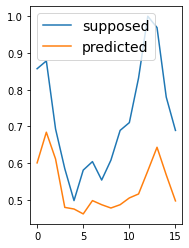

In [32]:
plt.subplot(1, 2, 2)
#supposed = dataset[train_size:len(dataset):]
plt.plot(testY, label='supposed')
plt.plot(prediction, label='predicted')
plt.legend(fontsize=14)
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: